In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from hottbox.core import Tensor, TensorTKD, residual_tensor
from hottbox.algorithms.decomposition import HOSVD, HOOI
from coursework.data import get_image, plot_tensors

In [3]:
np.random.seed(0)

[Return to Table of Contents](./0_Table_of_contents.ipynb)

# Tucker Decomposition

<img src="./imgs/TensorTKD.png" alt="Drawing" style="width: 500px;"/>

In previous [assignment](./2_Efficient_representation_of_multidimensional_arrays.ipynb), you have been provided materials which cover efficient representations of mutlidimensional arrays of data, such as the Tucker form. In this module, you will take a closer look at it and the assiciated computational methods.


Any tensor of arbitrarily large order can be decomposed in the Tucker form. As illustrated above, a tensor $\mathbf{\underline{X}} \in \mathbb{R}^{I \times J \times K}$ can be represented as a dense core tensor $\mathbf{\underline{G}}$ and a set of factor matrices $\mathbf{A} \in \mathbb{R}^{I \times Q}, \mathbf{B} \in \mathbb{R}^{J \times R}$ and $\mathbf{C} \in
\mathbb{R}^{K \times P}$

$$
\mathbf{\underline{X}} = \mathbf{\underline{G}} \times_1 \mathbf{A} \times_2 \mathbf{B} \times_3 \mathbf{C} = \Big[    \mathbf{\underline{G}} ;  \mathbf{A},  \mathbf{B}, \mathbf{C}      \Big]
$$


On practice, there exist several computational methods to accomplish this all of which are combined into a Tucker Decomposition framework. The two most commonly used algorithms are:
1. Higher Order Singular Value Decomposition ([HOSVD](#Higher-Order-Singular-Value-Decomposition-(HOSVD)))
1. Higher Order Orthogonal Iteration ([HOOI](#Higher-Order-Orthogonal-Iteration-(HOOI)))


# Higher Order Singular Value Decomposition (HOSVD)

The HOSVD is a special case of the Tucker decomposition, in which all the factor matrices are constrained to be orthogonal. They are computed as truncated version of the left singular matrices of all possible mode-$n$ unfoldings of tensor $\mathbf{\underline{X}}$:

$$
\begin{aligned}
\mathbf{X}_{(1)} &= \mathbf{U}_1  \mathbf{\Sigma}_1 \mathbf{V}_1^T \quad \rightarrow \quad \mathbf{A} = \mathbf{U}_1[1:R_1]\\
\mathbf{X}_{(2)} &= \mathbf{U}_2  \mathbf{\Sigma}_2 \mathbf{V}_2^T \quad \rightarrow \quad \mathbf{B} = \mathbf{U}_2[1:R_2] \\
\mathbf{X}_{(3)} &= \mathbf{U}_3  \mathbf{\Sigma}_3 \mathbf{V}_3^T \quad \rightarrow \quad \mathbf{C} = \mathbf{U}_3[1:R_3] \\
\end{aligned}
$$

After factor matrices are obtained, the core tensor $\mathbf{\underline{G}}$ is computed as

$$
\mathbf{\underline{G}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^T \times_2 \mathbf{B}^T \times_3 \mathbf{C}^T        
$$


# Higher Order Orthogonal Iteration (HOOI)

HOOI algorithm is another special case of the Tuker decomposition. Like HOSVD, it decomposes a tensor into a dense core tensor and orthogonal factor matrices. The difference between the two lies in the fact that in HOOI the factor matrices are optimized iteratively using an Alternating Least Squares (ALS) approach. In other words, the tucker representation $[ \mathbf{\underline{G}};\mathbf{A}^{(1)}, \mathbf{A}^{(2)}, \cdots,\mathbf{A}^{(N)} ]$ of the given tensor $\mathbf{\underline{X}}$ is obtained through the HOOI as follows

$$
\begin{aligned}
&\mathbf{\underline{Y}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^{(1)T} \times_2 \cdots \times_{n-1} \mathbf{A}^{(n-1)T} \times_{n+1} \mathbf{A}^{(n+1)} \times \cdots \times_N \mathbf{A}^{(N)} \\
&\mathbf{A}^{(n)} \leftarrow R_n \text{ leftmost singular vectors of } \mathbf{Y}_{(n)}
\end{aligned}
$$

The above is repeated until convergence, then the core tensor $\mathbf{\underline{G}} \in \mathbb{R}^{R_1 \times R_2 \times \cdots \times R_N}$ is computed as

$$
\mathbf{\underline{G}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^{(1)T}  \times_2 \mathbf{A}^{(2)T} \times_3 \cdots  \times_N \mathbf{A}^{(N)T}
$$

# Multi-linear rank

The **multi-linear rank** of a tensor $\mathbf{\underline{X}} \in \mathbb{R}^{I_1 \times \cdots \times I_N}$ is the $N$-tuple $(R_1, \dots, R_N)$ where each $R_n$ is the rank of the subspace spanned by mode-$n$ fibers, i.e. $R_n = \text{rank} \big( \mathbf{X}_{(n)} \big)$. Thus, for our order-$3$ tensor the multi-linear rank is $(R_1, R_2, R_3)$. Multi-linear rank provides flexibility in compression and approximation of the original tensor.

> **NOTE:** For a tensor of order $N$ the values $R_1, R_2, \dots , R_N$ are not necessarily the same, whereas, for matrices (tensors of order 2) the equality $R_1 = R_2$ always holds, where $R_1$ and $R_2$ are the matrix column rank and row rank respectively.



# Performing tensor decomposition

In [4]:
# Create tensor
I, J, K = 5, 6, 7
array_3d = np.random.rand(I * J * K).reshape((I, J, K)).astype(np.float)
tensor = Tensor(array_3d)

# Initialise algorithm
algorithm = HOSVD()

# Perform decomposing for selected multi-linear rank
ml_rank = (4, 5, 6)
tensor_tkd = algorithm.decompose(tensor, ml_rank)

# Result preview
print(tensor_tkd)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_tkd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_tkd.core)

Tucker representation of a tensor with multi-linear rank=(4, 5, 6).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (5, 6, 7) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (5, 4)
Mode-1 factor matrix is of shape (6, 5)
Mode-2 factor matrix is of shape (7, 6)

	Core tensor
This tensor is of order 3 and consists of 120 elements.
Sizes and names of its modes are (4, 5, 6) and ['mode-0', 'mode-1', 'mode-2'] respectively.


# Evaluation and reconstruction

Tucker representation of an original tensor is almost always an approximation, regardless of which algorithm has been employed for performing decomposition. Thus, relative error of approximation is commonly used in order to evaluate performance of computational methods, i.e. the ratio between a Frobenious norms of residual and original tensors.

In [5]:
# Compute residual tensor
tensor_res = residual_tensor(tensor, tensor_tkd)

# Compute error of approximation
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))

Relative error of approximation = 0.21320264561618077


## **Assigment 1**

1. Create a tensor of order 4 with sizes of each mode being defined by prime numbers and  obtain a Tucker representation using HOOI algorithm with multi-linear (4, 10, 6, 2). Then calculation ratio between the number of elements in the original tensor and its Tucker form.

1. For a tensor that consists of 1331 elements, which multi-linear rank guarantees a perfect reconstruction from its Tucker form and why. Is such choice reasonable for practical applications?


### Solution: Part 1

In [6]:
# Create tensor
I, J, K, L = 5, 11, 7, 3
array_4d = np.random.rand(I * J * K * L).reshape((I, J, K, L)).astype(np.float)
tensor = Tensor(array_4d)

print(tensor)

This tensor is of order 4 and consists of 1155 elements.
Sizes and names of its modes are (5, 11, 7, 3) and ['mode-0', 'mode-1', 'mode-2', 'mode-3'] respectively.


In [7]:
# Initialise algorithm
algorithm = HOSVD()

# Perform decomposing for selected multi-linear rank
ml_rank = (4, 10, 6, 2)
tensor_tkd = algorithm.decompose(tensor, ml_rank)

# Result preview
print(tensor_tkd)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_tkd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_tkd.core)

Tucker representation of a tensor with multi-linear rank=(4, 10, 6, 2).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2', 'mode-3']
With corresponding latent components described by (5, 11, 7, 3) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (5, 4)
Mode-1 factor matrix is of shape (11, 10)
Mode-2 factor matrix is of shape (7, 6)
Mode-3 factor matrix is of shape (3, 2)

	Core tensor
This tensor is of order 4 and consists of 480 elements.
Sizes and names of its modes are (4, 10, 6, 2) and ['mode-0', 'mode-1', 'mode-2', 'mode-3'] respectively.


In [15]:
# Compute residual tensor
tensor_res = residual_tensor(tensor, tensor_tkd)

# Compute error of approximation
rel_error = tensor_res.frob_norm / tensor.frob_norm

#Compute number of elements in TKD form (sum of elements in factor matrices and core tensor)
numel = (5*4)+(11*10)+(7*6)+(3*2) + 480

print("Relative error of approximation = {}".format(rel_error))
print("Ratio of number of elements in original tensor with respect to TKD form = {}".format(1155/numel))
print("As expected this ratio is greater than 1, showing that data compression was achieved.")

Relative error of approximation = 0.35749132360735514
Ratio of number of elements in original tensor with respect to TKD form = 1.7553191489361701
As expected this ratio is greater than 1, showing that data compression was achieved.


### Solution: Part 2

A tensor can be perfectly reconstructed from its TKD form if the selected multi-linear rank for each mode equals the size of that mode. In this setting, the compression ratio achieved with TKD is minimal and equals $1$, therefore this choice would not be reasonable in practical application given that under TKD large data compression factors can be achieved for negligible relative error of approximation.

In the case of a tensor comprising 1331 elements, we could imagine a tensor of order 3 with mode sizes (11,11,11), which would contain 11^3=1331 elements.

# Application: Image compression 

Color images can be naturally represented as a tensor of order three with the shape `(height x width x channels)` where channels are, for example, Red, Blue and Green (RGB)

<img src="./imgs/image_to_base_colors.png" alt="Drawing" style="width: 500px;"/>

By keeping its original structure, allows to apply methods from multi-linear analysis. For instance, we can employ algorithms for Tucker decompositions in order to commress oringinal informaiton by varying values of desired multi-linear rank.

```python
# Get data in form of a Tensor
car = get_image(item="car", view="top")
tensor = Tensor(car)

# Initialise algorithm and preform decomposition
algorithm = HOSVD()
tensor_tkd = algorithm.decompose(tensor, rank=(25, 25, 3))

# Evaluate result
tensor_res = residual_tensor(tensor, tensor_tkd)
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))
```

When can also visually inspect image obtained by reconstructing the Tucker representation
```python
# Reconstruction
tensor_rec = tensor_tkd.reconstruct()

# Plot original and reconstructed images side by side
plot_tensors(tensor, tensor_rec)
```

<img src="./imgs/car_orig_vs_reconstructed_25_25_3.png" alt="Drawing" style="width: 500px;"/>

## **Assigment 2**
For this assignment you are provided with function `get_image()` which requires two parameters: `item` and `view`. The valid values for former are **car** and **apple**, while the latter takes only **side** and **top**. 

1. Use multi-linear rank equal to `(50, 50, 2)` in order to obtain Tucker representations of images of the car and apple. Analyse results by visually inspecting their reconstructions.

1. Use multi-linear rank equal to `(50, 50, 2)` in order to obtain Tucker representations of images of the apple taken from the top and from the side. Analyse results by visually inspecting their reconstructions.

1. What would happen to the reconstruction if the value of multi-linear rank corresponding to the channel mode is decreased to 1.


### Solution: Part 1

In [9]:
# Create tensor from car image
car = get_image(item="car", view="top")
tensor_car = Tensor(car)
print(tensor_car)

# Create tensor from apple image
apple = get_image(item="apple", view="top")
tensor_apple = Tensor(apple)
print(tensor_apple)

This tensor is of order 3 and consists of 49152 elements.
Sizes and names of its modes are (128, 128, 3) and ['mode-0', 'mode-1', 'mode-2'] respectively.
This tensor is of order 3 and consists of 49152 elements.
Sizes and names of its modes are (128, 128, 3) and ['mode-0', 'mode-1', 'mode-2'] respectively.


In [10]:
# Initialise algorithm and preform decompositions
algorithm = HOSVD()
tensor_tkd_apple = algorithm.decompose(tensor_apple, rank=(50, 50, 2))
print(tensor_tkd_apple)
tensor_tkd_car = algorithm.decompose(tensor_car, rank=(50, 50, 2))
print(tensor_tkd_car)

Tucker representation of a tensor with multi-linear rank=(50, 50, 2).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (128, 128, 3) features respectively.
Tucker representation of a tensor with multi-linear rank=(50, 50, 2).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (128, 128, 3) features respectively.


Relative error of approximation for the car image = 0.04991577804571508
Relative error of approximation for the apple image = 0.03706225838740835


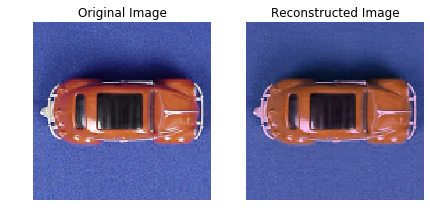

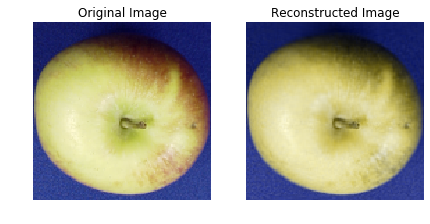

In [11]:
# Evaluate results
tensor_res_car = residual_tensor(tensor_car, tensor_tkd_car)
rel_error_car = tensor_res_car.frob_norm / tensor_car.frob_norm
tensor_res_apple = residual_tensor(tensor_apple, tensor_tkd_apple)
rel_error_apple = tensor_res_apple.frob_norm / tensor_apple.frob_norm

print("Relative error of approximation for the car image = {}".format(rel_error_car))
print("Relative error of approximation for the apple image = {}".format(rel_error_apple))

# Reconstruction
tensor_rec_apple = tensor_tkd_apple.reconstruct()
tensor_rec_car = tensor_tkd_car.reconstruct()

# Plot original and reconstructed images side by side
plot_tensors(tensor_car, tensor_rec_car)
plot_tensors(tensor_apple, tensor_rec_apple)

The results obtained show that the relative error of approximation metric does not exactly correlate with the extent to which visual information has been lost for a human observer: indeed, while the relative error of appoximation is higher for the car image ($0.05$) than for the apple image ($0.04$), we note that the original and reconstructed car images appear equivalent to a human observer, while in the case of the apple image the red pigmentation of the apple is missing in the reconstructed image with respect to the original image. Since this red pigmentation could be interpreted by a human observer as an indicator of ripeness or as a distinctive feature of a specific variety of apple, some information has been "lost" in the case of the apple image, as opposed to the car image.

Overall, we observe that the original images have been compressed from mode sizes of (128,128,3) to multi-linear ranks of (50,50,2), while most of the visual information was conserved, which demonstrates the power of TKD algorithms and suggests their potential for Big Data applications. We also note that the process of Tucker compression-decompression conserves the original picture resolution by definition, even though the original images of resolution 128x128 are compressed to modes of size (50,50) under the application of TKD. The picture structure is conserved, and only the colouring is affected: this is again coherent with our method, since TKD compressed the RGB channel mode of size 3 to size 2. This means that one of the three independant components red, green, blue was lost (in this case, red), and by definition cannot be expressed as a linear combination of the other two, which results in a visible change in colour from the original image to the reconstructed equivalent.

### Solution: Part 2

In [12]:
# Create tensor from apple image, top
apple_top = get_image(item="apple", view="top")
tensor_top = Tensor(apple_top)
print(tensor_top)

# Create tensor from apple image, side
apple_side = get_image(item="apple", view="side")
tensor_side = Tensor(apple_side)
print(tensor_side)

This tensor is of order 3 and consists of 49152 elements.
Sizes and names of its modes are (128, 128, 3) and ['mode-0', 'mode-1', 'mode-2'] respectively.
This tensor is of order 3 and consists of 49152 elements.
Sizes and names of its modes are (128, 128, 3) and ['mode-0', 'mode-1', 'mode-2'] respectively.


In [13]:
# Initialise algorithm and preform decompositions
algorithm = HOSVD()
tensor_tkd_top = algorithm.decompose(tensor_top, rank=(50, 50, 2))
print(tensor_tkd_top)
tensor_tkd_side = algorithm.decompose(tensor_side, rank=(50, 50, 2))
print(tensor_tkd_side)

Tucker representation of a tensor with multi-linear rank=(50, 50, 2).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (128, 128, 3) features respectively.
Tucker representation of a tensor with multi-linear rank=(50, 50, 2).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (128, 128, 3) features respectively.


Relative error of approximation for the top apple view = 0.03706225838740811
Relative error of approximation for the side apple view = 0.06574690406026355


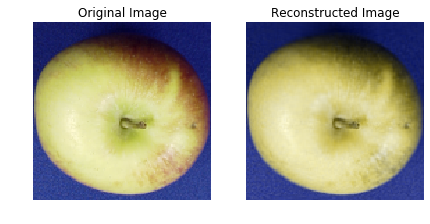

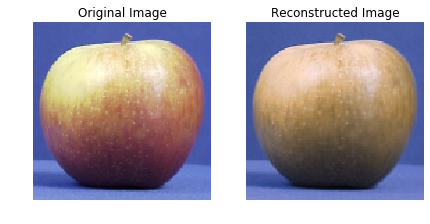

In [14]:
# Evaluate results
tensor_res_top = residual_tensor(tensor_top, tensor_tkd_top)
rel_error_top = tensor_res_top.frob_norm / tensor_top.frob_norm
tensor_res_side = residual_tensor(tensor_side, tensor_tkd_side)
rel_error_side = tensor_res_side.frob_norm / tensor_side.frob_norm

print("Relative error of approximation for the top apple view = {}".format(rel_error_top))
print("Relative error of approximation for the side apple view = {}".format(rel_error_side))

# Reconstruction
tensor_rec_top = tensor_tkd_top.reconstruct()
tensor_rec_side = tensor_tkd_side.reconstruct()

# Plot original and reconstructed images side by side
plot_tensors(tensor_top, tensor_rec_top)
plot_tensors(tensor_side, tensor_rec_side)

The results obtained confirm what was suggested in the first part of this assignment. The original images have been compressed from mode sizes of (128,128,3) to multi-linear ranks of (50,50,2), while most of the visual information was conserved. While the process of Tucker compression-decompression conserves the original picture resolution by definition, and the image structure is conserved, the colouring is affected. Specifically, TKD compressed the RGB channel mode of size 3 to size 2, hence one of the three independant components red, green, blue was lost: in this case, red. Since by definition the red component cannot be expressed as a linear combination of the other two colours blue and green, we observe a visible change in the colour of the apple from the original image to the reconstructed equivalent. We suggest that selecting a multi-linear rank of (50,50,3) should solve this issue, at the cost of a reduction in compression gain.

### Solution: Part 3

If the value of multi-linear rank corresponding to the channel mode is decreased to 1, we would expect the reconstructed image to be monochrome as all three colours are independant and cannot be expressed as a linear combination of the other two (that is, the original image tensor is full-rank across the channel mode). The structure of the image should however remain unaffected.